In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip','5de26c8fce5ccdea9f91267273464dc968d20d72')

In [3]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images',f'{img_name}')))
    # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
    # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256


In [4]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    def __len__(self):
        return len(self.features)

In [5]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),batch_size, shuffle=True)
    val_iter =torch.utils.data.DataLoader(BananasDataset(is_train=False),batch_size)
    return train_iter, val_iter


In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape


read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

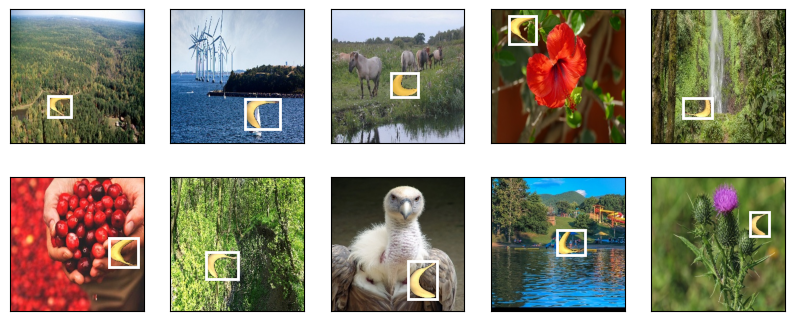

In [7]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [8]:
%matplotlib inline
import torch
from d2l import torch as d2l

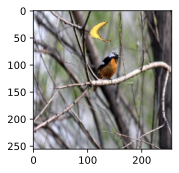

In [11]:
d2l.set_figsize()
img = d2l.plt.imread('/Users/sunxiaolei/Python_Projects/Deeplearning/experiment_eight/data/banana-detection/bananas_train/images/0.png')
d2l.plt.imshow(img)

In [12]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes
#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [13]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box = box_corner_to_center(boxes)
box

tensor([[219.0000, 280.5000, 318.0000, 471.0000],
        [527.5000, 302.5000, 255.0000, 381.0000]])

In [14]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [15]:
boxes = torch.tensor((dog_bbox, cat_bbox))
print(boxes)
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[ 60.,  45., 378., 516.],
        [400., 112., 655., 493.]])


tensor([[True, True, True, True],
        [True, True, True, True]])

In [16]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],fill=False, edgecolor=color, linewidth=2)

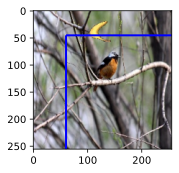

In [17]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))